In [1]:
!pip install imutils

In [2]:
import numpy as np
import cv2
from sklearn.cluster import KMeans
from collections import Counter
import imutils
import pprint
from matplotlib import pyplot as plt

In [3]:
def extractSkin(image):
  # Taking a copy of the image
  img =  image.copy()
  # Converting from BGR Colours Space to HSV
  img =  cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
  
  # Defining HSV Threadholds
  lower_threshold = np.array([0, 48, 80], dtype=np.uint8)
  upper_threshold = np.array([20, 255, 255], dtype=np.uint8)
  
  # Single Channel mask,denoting presence of colours in the about threshold
  skinMask = cv2.inRange(img,lower_threshold,upper_threshold)
  
  # Cleaning up mask using Gaussian Filter
  skinMask = cv2.GaussianBlur(skinMask,(3,3),0)
  
  # Extracting skin from the threshold mask
  skin  =  cv2.bitwise_and(img,img,mask=skinMask)
  
  # Return the Skin image
  return cv2.cvtColor(skin,cv2.COLOR_HSV2BGR)


In [4]:
def removeBlack(estimator_labels, estimator_cluster):
  
  
  # Check for black
  hasBlack = False
  
  # Get the total number of occurance for each color
  occurance_counter = Counter(estimator_labels)

  
  # Quick lambda function to compare to lists
  compare = lambda x, y: Counter(x) == Counter(y)
   
  # Loop through the most common occuring color
  for x in occurance_counter.most_common(len(estimator_cluster)):
    
    # Quick List comprehension to convert each of RBG Numbers to int
    color = [int(i) for i in estimator_cluster[x[0]].tolist() ]
    
  
    
    # Check if the color is [0,0,0] that if it is black 
    if compare(color , [0,0,0]) == True:
      # delete the occurance
      del occurance_counter[x[0]]
      # remove the cluster 
      hasBlack = True
      estimator_cluster = np.delete(estimator_cluster,x[0],0)
      break
      
   
  return (occurance_counter,estimator_cluster,hasBlack)
    
    

In [5]:
def getColorInformation(estimator_labels, estimator_cluster,hasThresholding=False):
  
  # Variable to keep count of the occurance of each color predicted
  occurance_counter = None
  
  # Output list variable to return
  colorInformation = []
  
  
  #Check for Black
  hasBlack =False
  
  # If a mask has be applied, remove th black
  if hasThresholding == True:
    
    (occurance,cluster,black) = removeBlack(estimator_labels,estimator_cluster)
    occurance_counter =  occurance
    estimator_cluster = cluster
    hasBlack = black
    
  else:
    occurance_counter = Counter(estimator_labels)
 
  # Get the total sum of all the predicted occurances
  totalOccurance = sum(occurance_counter.values()) 
  
 
  # Loop through all the predicted colors
  for x in occurance_counter.most_common(len(estimator_cluster)):
    
    index = (int(x[0]))
    
    # Quick fix for index out of bound when there is no threshold
    index =  (index-1) if ((hasThresholding & hasBlack)& (int(index) !=0)) else index
    
    # Get the color number into a list
    color = estimator_cluster[index].tolist()
    
    # Get the percentage of each color
    color_percentage= (x[1]/totalOccurance)
    
    #make the dictionay of the information
    colorInfo = {"cluster_index":index , "color": color , "color_percentage" : color_percentage }
    
    # Add the dictionary to the list
    colorInformation.append(colorInfo)
    
      
  return colorInformation 

In [6]:

def extractDominantColor(image,number_of_colors=5,hasThresholding=False):
  
  # Quick Fix Increase cluster counter to neglect the black(Read Article) 
  if hasThresholding == True:
    number_of_colors +=1
  
  # Taking Copy of the image
  img = image.copy()
  
  # Convert Image into RGB Colours Space
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  
  # Reshape Image
  img = img.reshape((img.shape[0]*img.shape[1]) , 3)
  
  #Initiate KMeans Object
  estimator = KMeans(n_clusters=number_of_colors, random_state=0)
  
  # Fit the image
  estimator.fit(img)
  
  # Get Colour Information
  colorInformation = getColorInformation(estimator.labels_,estimator.cluster_centers_,hasThresholding)
  return colorInformation
  
  

In [7]:
def plotColorBar(colorInformation):
  #Create a 500x100 black image
  color_bar = np.zeros((100,500,3), dtype="uint8")
  
  top_x = 0
  for x in colorInformation:    
    bottom_x = top_x + (x["color_percentage"] * color_bar.shape[1])

    color = tuple(map(int,(x['color'])))
  
    cv2.rectangle(color_bar , (int(top_x),0) , (int(bottom_x),color_bar.shape[0]) ,color , -1)
    top_x = bottom_x
  return color_bar

In [8]:
def prety_print_data(color_info):
  for x in color_info:
    print(pprint.pformat(x))
    print()

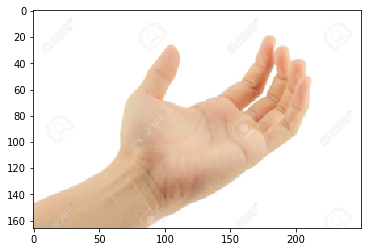

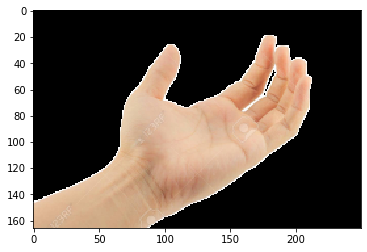

Color Information
{'cluster_index': 4,
 'color': [222.598796180978, 181.06039850560182, 148.25508509755662],
 'color_percentage': 0.32252457043524774}

{'cluster_index': 0,
 'color': [230.94268867923876, 196.51084905660187, 167.71108490566644],
 'color_percentage': 0.2816741325132045}

{'cluster_index': 1,
 'color': [210.94620253164982, 164.2737341772168, 129.6049578059111],
 'color_percentage': 0.2550645182857525}

{'cluster_index': 2,
 'color': [194.75372604684455, 134.01277501774393, 100.11142654364917],
 'color_percentage': 0.09406966637694725}

{'cluster_index': 3,
 'color': [248.30372492836847, 243.83094555874038, 238.28223495701798],
 'color_percentage': 0.046667112388848034}

Color Bar


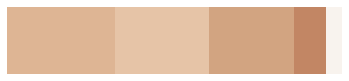

In [9]:
# Get Image from URL. If you want to upload an image file and use that comment the below code and replace with  image=cv2.imread("FILE_NAME")
image =  imutils.url_to_image("https://raw.githubusercontent.com/octalpixel/Skin-Extraction-from-Image-and-Finding-Dominant-Color/master/82764696-open-palm-hand-gesture-of-male-hand_image_from_123rf.com.jpg")

# Resize image to a width of 250
image = imutils.resize(image,width=250)

#Show image
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.show()


# Apply Skin Mask
skin = extractSkin(image)

plt.imshow(cv2.cvtColor(skin,cv2.COLOR_BGR2RGB))
plt.show()



# Find the dominant color. Default is 1 , pass the parameter 'number_of_colors=N' where N is the specified number of colors 
dominantColors = extractDominantColor(skin,hasThresholding=True)




#Show in the dominant color information
print("Color Information")
prety_print_data(dominantColors)


#Show in the dominant color as bar
print("Color Bar")
colour_bar = plotColorBar(dominantColors)
plt.axis("off")
plt.imshow(colour_bar)
plt.show()


